# Project 2 Image Segmentation ([Semantic Segmentation for Self Driving Cars](https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge/code))

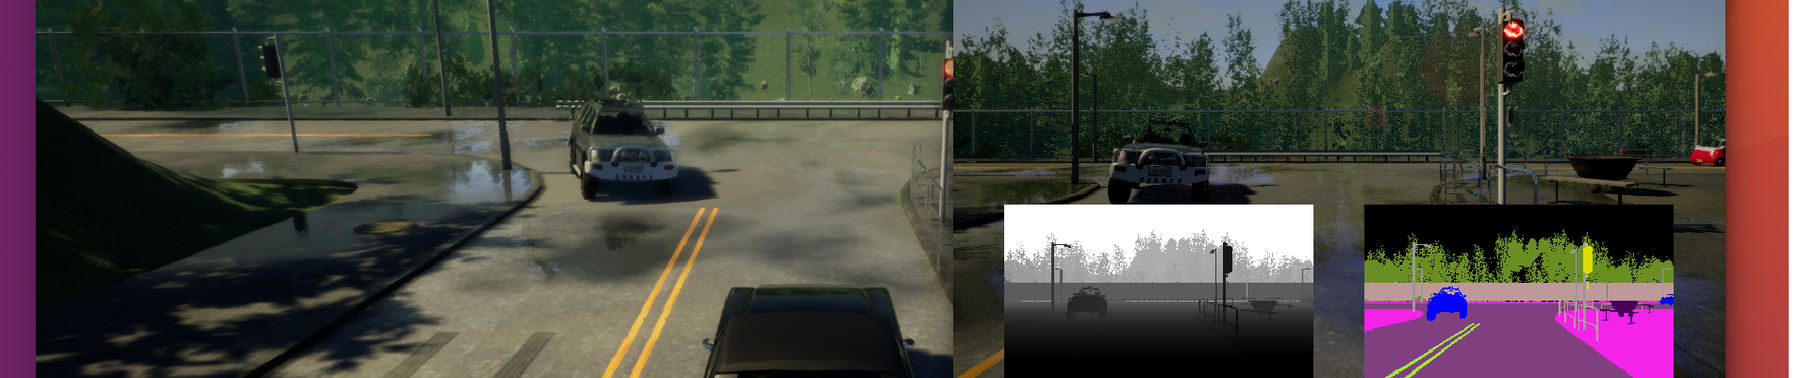


## About the dataset

The dataset "Semantic Segmentation for Self Driving Cars" provides RGB images and corresponding labeled semantic segmentations, captured using the CARLA self-driving car simulator. Its purpose is to aid in training machine learning algorithms for semantic segmentation, where each pixel in an image is labeled with a class indicating the object or category it belongs to. The dataset includes labels for elements like cars, roads, and other objects in the scene.

In my project, I will utilize this dataset to develop an image segmentation model using deep learning techniques such as U-Net or DeepLab. This model will accurately label each pixel in the images, categorizing them into classes like cars, roads, and other objects. The primary goal is to achieve precise and detailed semantic segmentation results, which can be applied in self-driving car systems for better environmental understanding. To assess the model's performance, I will use evaluation metrics like Intersection over Union (IoU) and pixel accuracy. Additionally, I will fine-tune the model to enhance its segmentation performance, as required.

# Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import random
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image

import torch
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from torch.nn import functional as F

## Semantic Segmentation Model Preparation and Visualization using TensorFlow and Keras

Text(0.5, 1.0, 'Segmentation')

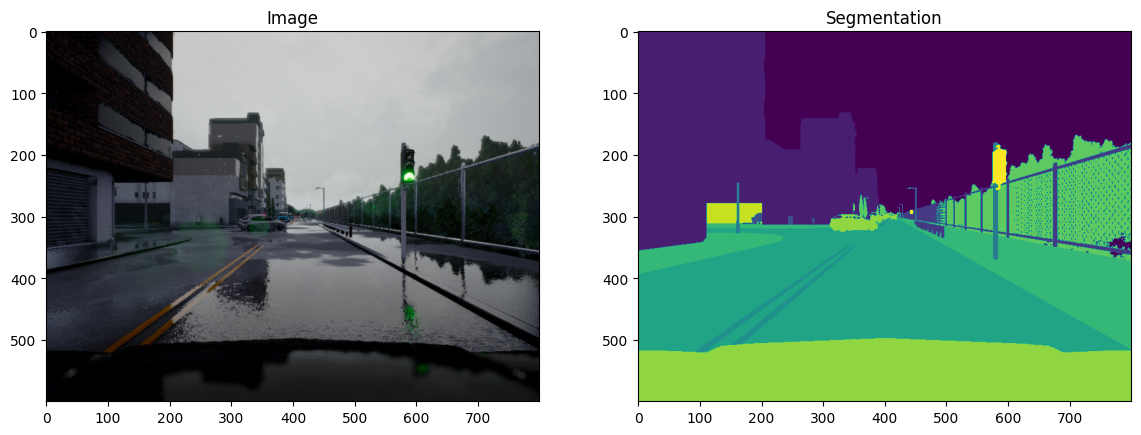

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio.v2 as imageio

import matplotlib.pyplot as plt

image_path = ('D:/Jupyter/Integrify/Deep Learning projects - Integrify/Project 9 Self-driving car navigation CV/dataA/CameraRGB/')
mask_path = ('D:/Jupyter/Integrify/Deep Learning projects - Integrify/Project 9 Self-driving car navigation CV/dataA/CameraSeg/')
test_path = ('D:/Jupyter/Integrify/Deep Learning projects - Integrify/Project 9 Self-driving car navigation CV/dataB/CameraRGB/')
test_mask = ('D:/Jupyter/Integrify/Deep Learning projects - Integrify/Project 9 Self-driving car navigation CV/dataB/CameraSeg/')

image_list = sorted(os.listdir(image_path))
mask_list = sorted(os.listdir(mask_path))
test_image_list = sorted(os.listdir(test_path))
test_mask_list = sorted(os.listdir(test_mask))
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]
test_image_list = [test_path+i for i in test_image_list]
test_mask_list = [test_mask+i for i in test_mask_list]
img = imageio.imread(image_list[12])
mask = imageio.imread(mask_list[12])
    #mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:,:,0])
arr[1].set_title('Segmentation')

## Shape of the mask

In [2]:
mask.shape
(600, 800, 3)

(600, 800, 3)

## Creating TensorFlow Datasets for Semantic Segmentation Model Training

In [3]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)
test_image_list_ds = tf.data.Dataset.list_files(test_image_list, shuffle=False)
test_mask_list_ds = tf.data.Dataset.list_files(test_mask_list, shuffle=False)


image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)
test_image_filenames = tf.constant(test_image_list)
test_masks_filenames = tf.constant(test_mask_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'D:/Jupyter/Integrify/Deep Learning projects - Integrify/Project 9 Self-driving car navigation CV/dataA/CameraRGB/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'D:/Jupyter/Integrify/Deep Learning projects - Integrify/Project 9 Self-driving car navigation CV/dataA/CameraSeg/02_00_000.png', shape=(), dtype=string)


## Data Preprocessing for Semantic Segmentation Model Training

In [4]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) #/255

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True) #255
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
test_image_ds = test_dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
test_processed_image_ds = test_image_ds.map(preprocess)

## Convolutional Downsampling Block for Semantic Segmentation

In [5]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)   
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size = (2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

## Convolutional Upsampling Block for Semantic Segmentation

In [6]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

# U-Net Semantic Segmentation Model Architecture

In [7]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

### U-Net Semantic Segmentation Model Instance and Summary

In [8]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 96, 128, 32)          896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 96, 128, 32)          9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 48, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

## U-Net Model Compilation and Sample Image-Mask Display

In [9]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

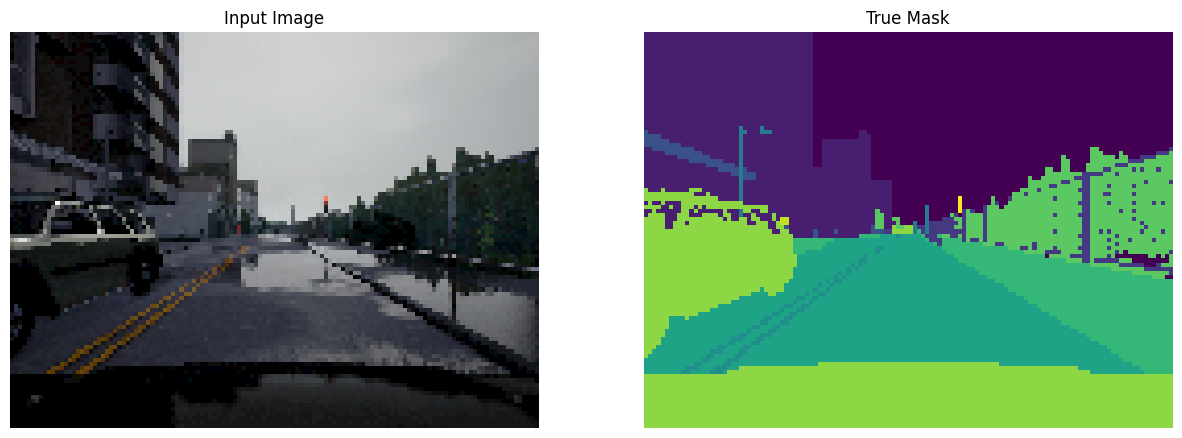

In [11]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])


## U-Net Model Training with Processed Dataset

In [12]:
EPOCHS = 10
VAL_SUBSPLITS = 10
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/10
32/32 [==============================] - 147s 4s/step - loss: 2.2016 - accuracy: 0.3690
Epoch 2/10
32/32 [==============================] - 132s 4s/step - loss: 1.1242 - accuracy: 0.6337
Epoch 3/10
32/32 [==============================] - 134s 4s/step - loss: 0.7299 - accuracy: 0.7749
Epoch 4/10
32/32 [==============================] - 135s 4s/step - loss: 0.5574 - accuracy: 0.8155
Epoch 5/10
32/32 [==============================] - 135s 4s/step - loss: 0.5044 - accuracy: 0.8344
Epoch 6/10
32/32 [==============================] - 134s 4s/step - loss: 0.4467 - accuracy: 0.8556
Epoch 7/10
32/32 [==============================] - 135s 4s/step - loss: 0.4012 - accuracy: 0.8730
Epoch 8/10
32/32 [==============================] - 138s 4s/step - loss: 0.3603 - accuracy: 0.8878
Epoch 9/10
32/32 [==============================] - 134s 4s/step - loss: 0.3269 - accur

### Displaying U-Net Model Predictions on Test Dataset

1/1 [==============================] - 1s 1s/step


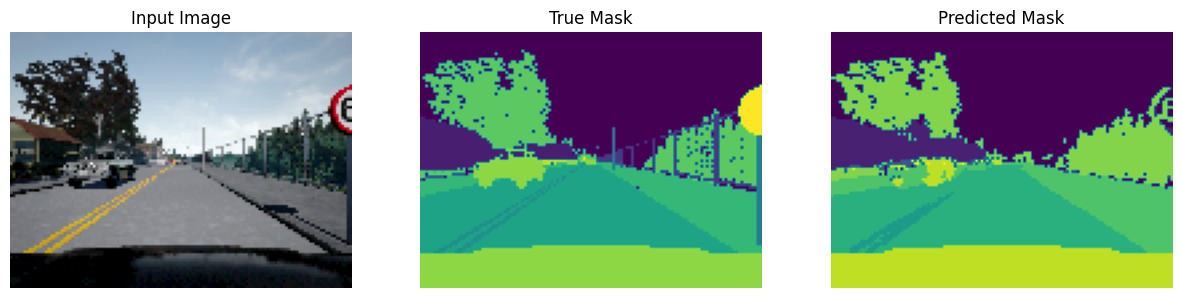

1/1 [==============================] - 1s 1s/step


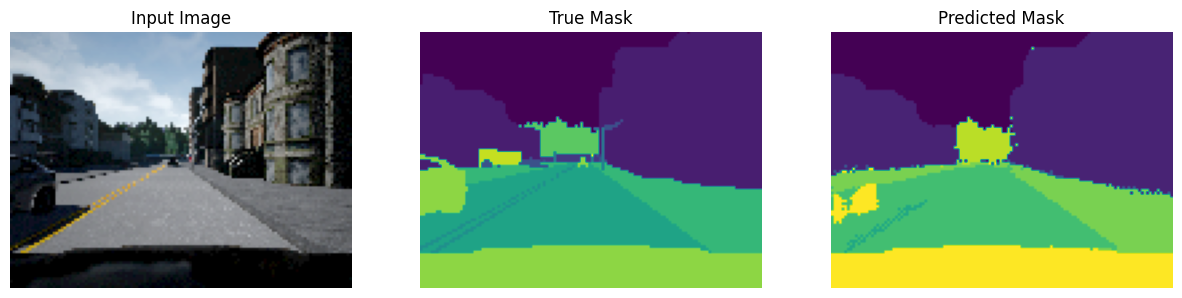

1/1 [==============================] - 1s 1s/step


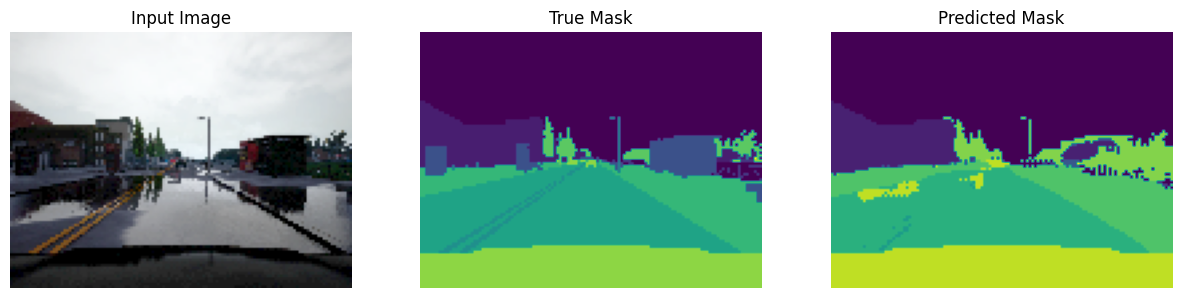

1/1 [==============================] - 1s 1s/step


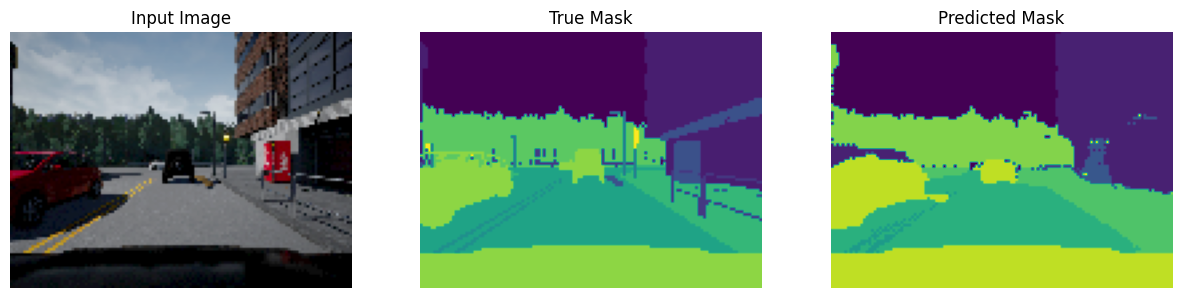

1/1 [==============================] - 1s 1s/step


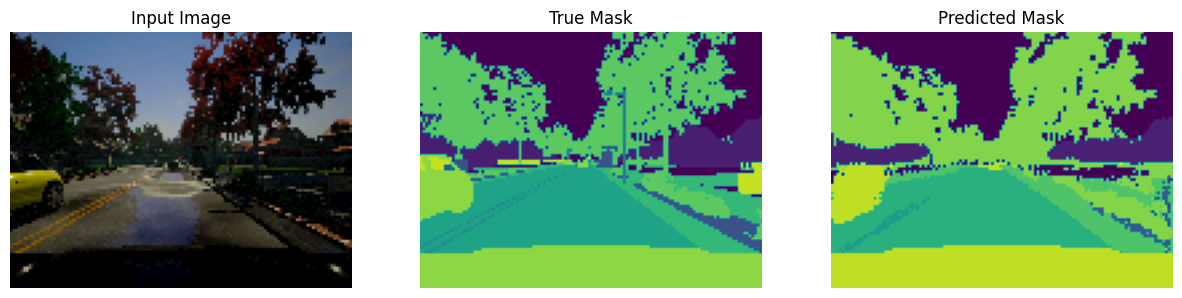

1/1 [==============================] - 1s 1s/step


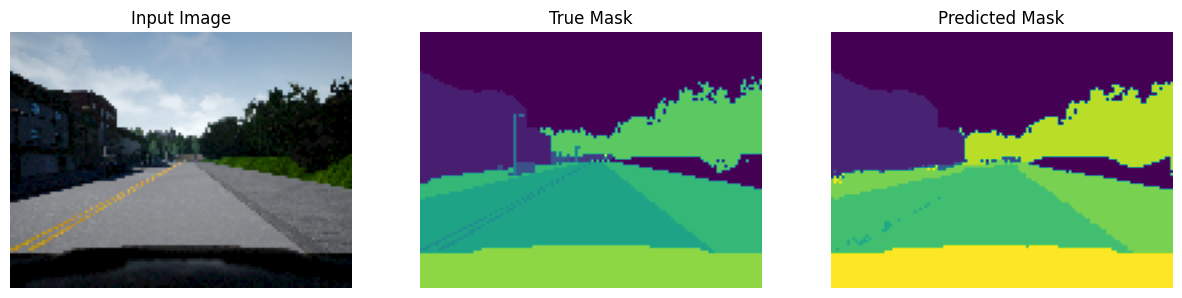

1/1 [==============================] - 1s 1s/step


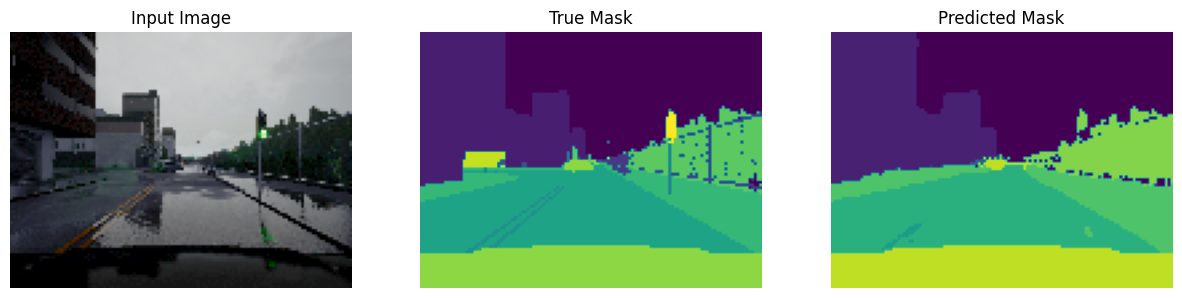

1/1 [==============================] - 1s 1s/step


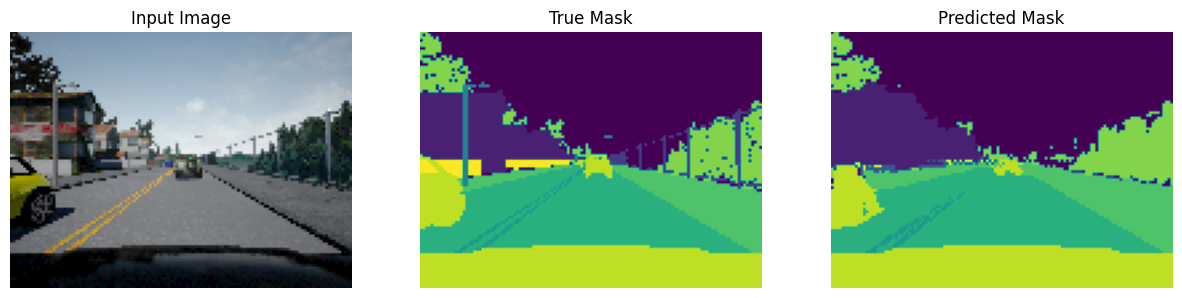

1/1 [==============================] - 1s 1s/step


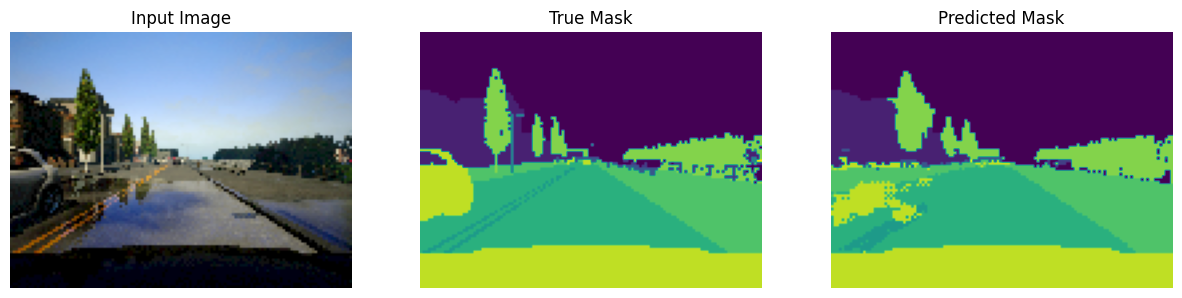

1/1 [==============================] - 1s 1s/step


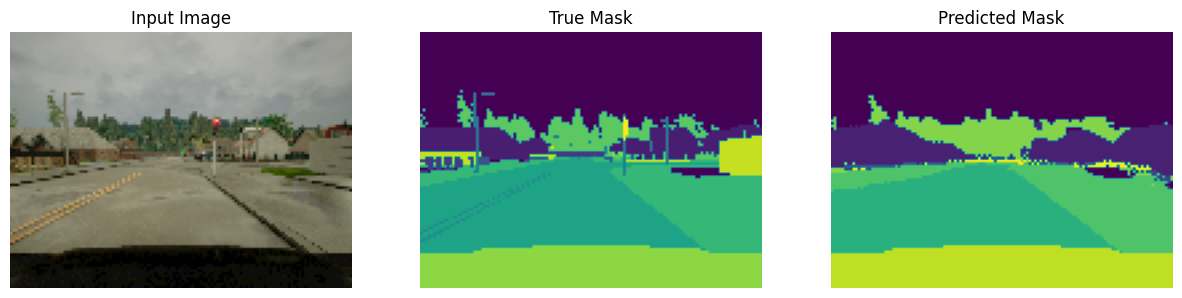

1/1 [==============================] - 1s 1s/step


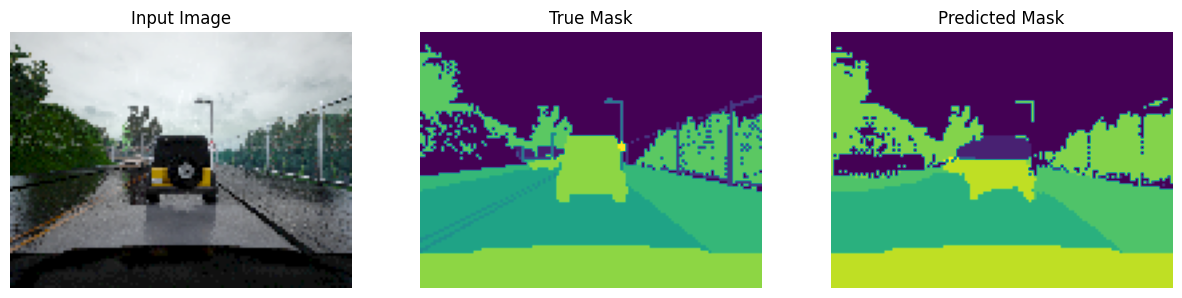

1/1 [==============================] - 1s 1s/step


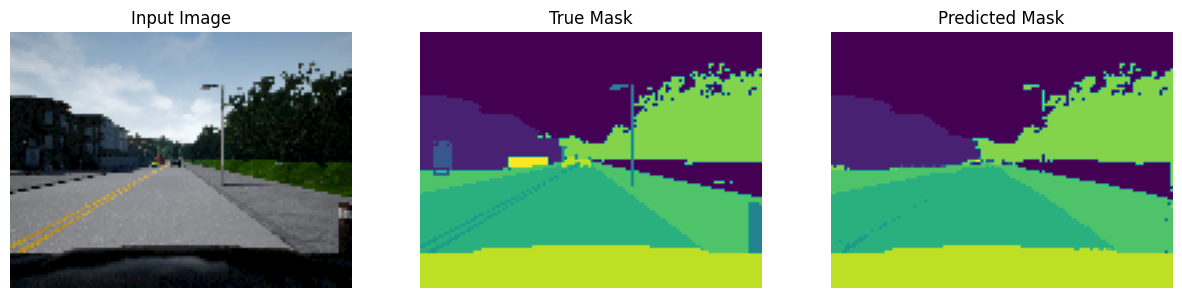

1/1 [==============================] - 1s 1s/step


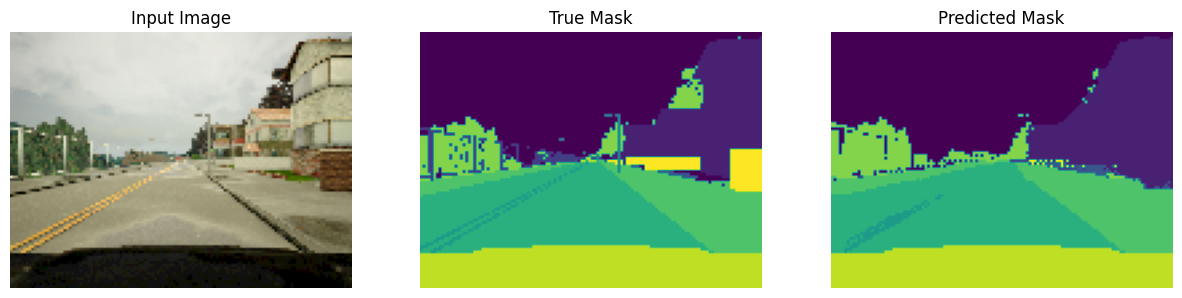

1/1 [==============================] - 1s 1s/step


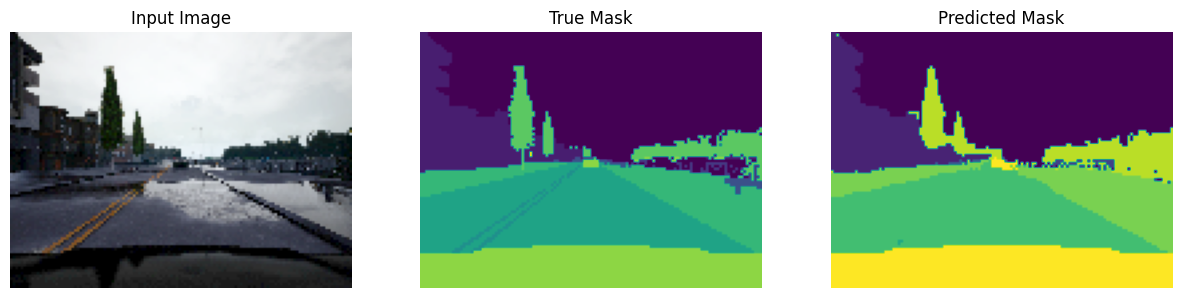

1/1 [==============================] - 1s 902ms/step


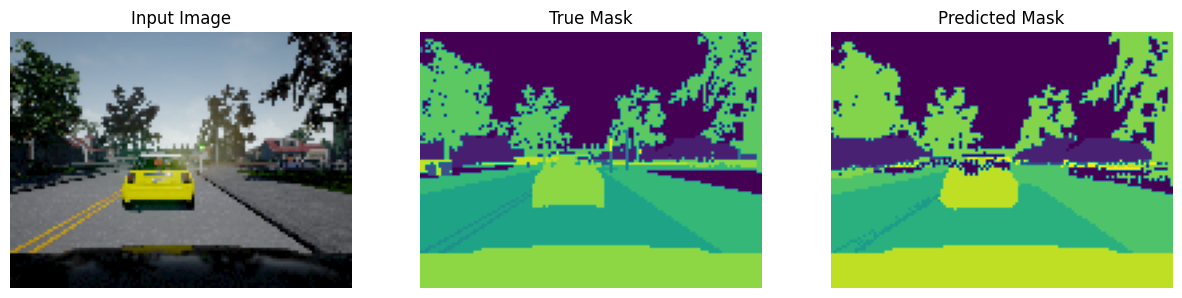

1/1 [==============================] - 1s 868ms/step


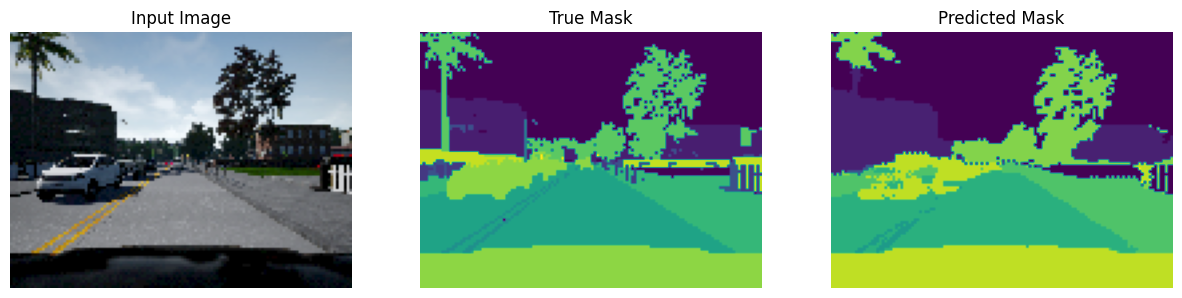

1/1 [==============================] - 1s 818ms/step


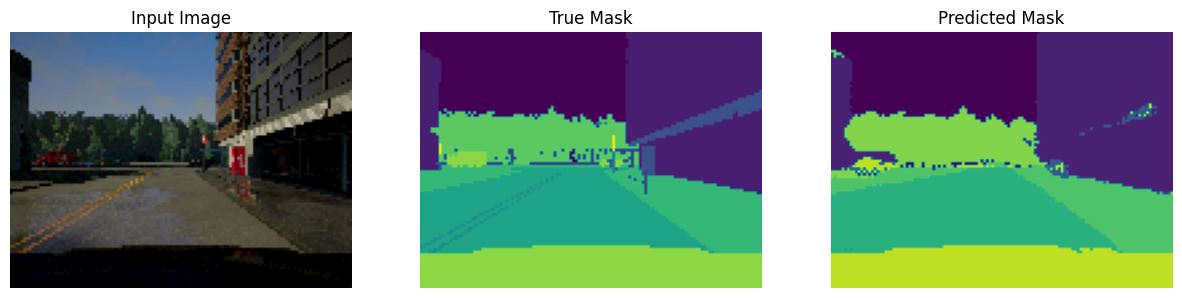

1/1 [==============================] - 1s 869ms/step


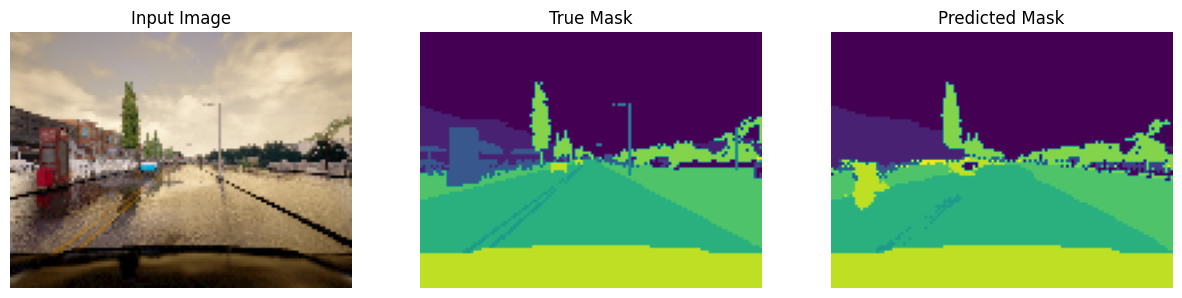

1/1 [==============================] - 1s 832ms/step


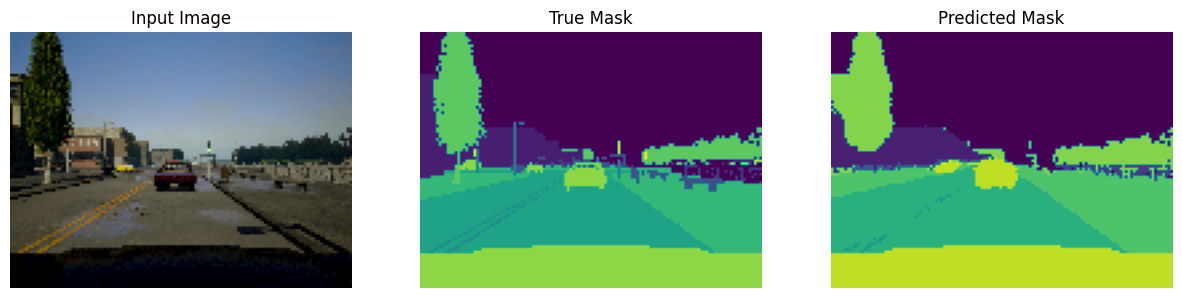

1/1 [==============================] - 1s 857ms/step


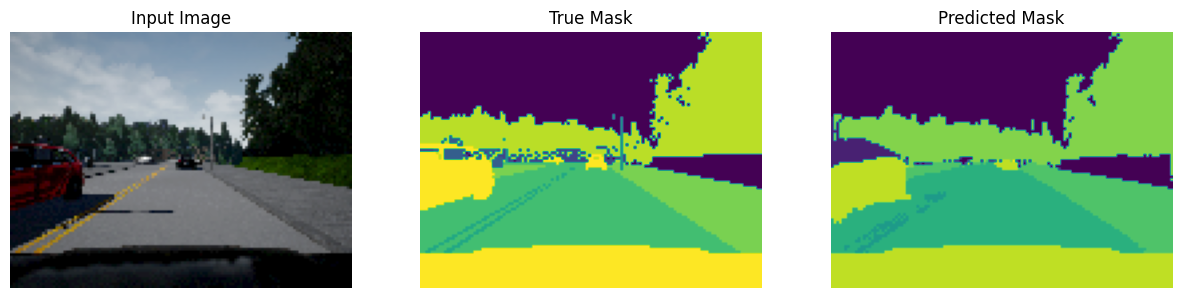

1/1 [==============================] - 1s 828ms/step


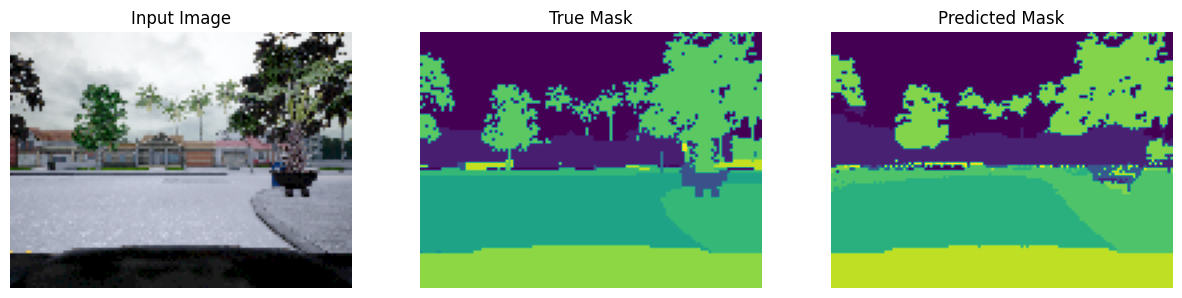

1/1 [==============================] - 1s 823ms/step


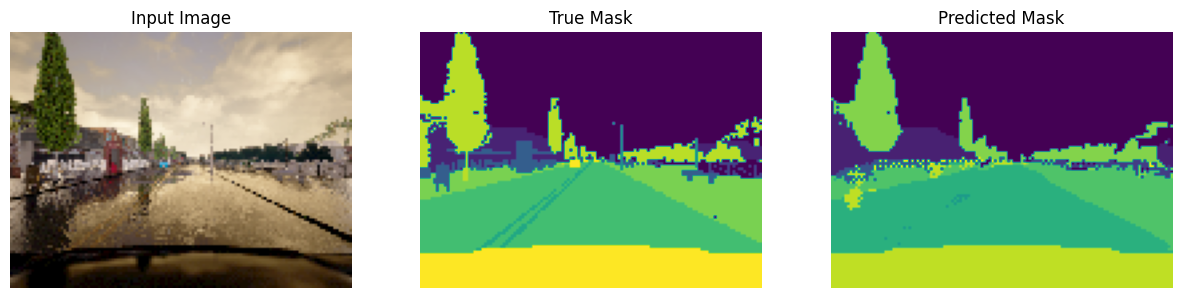

1/1 [==============================] - 1s 826ms/step


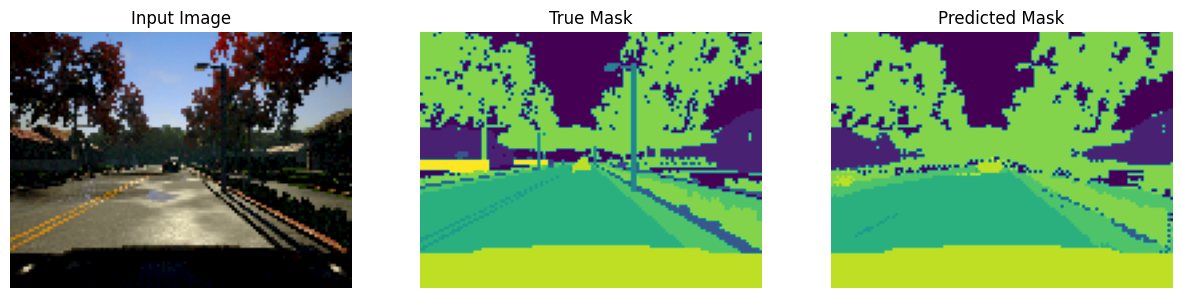

1/1 [==============================] - 1s 826ms/step


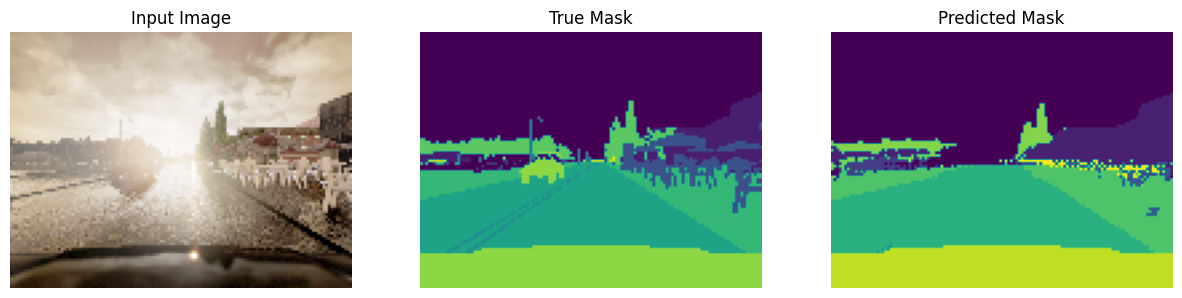

In [13]:
tests_dataset = test_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])
show_predictions(tests_dataset, 24)